
=== CIFAR-10 Classification: Optimizer and Scheduler Comparison ===
Using device: cuda


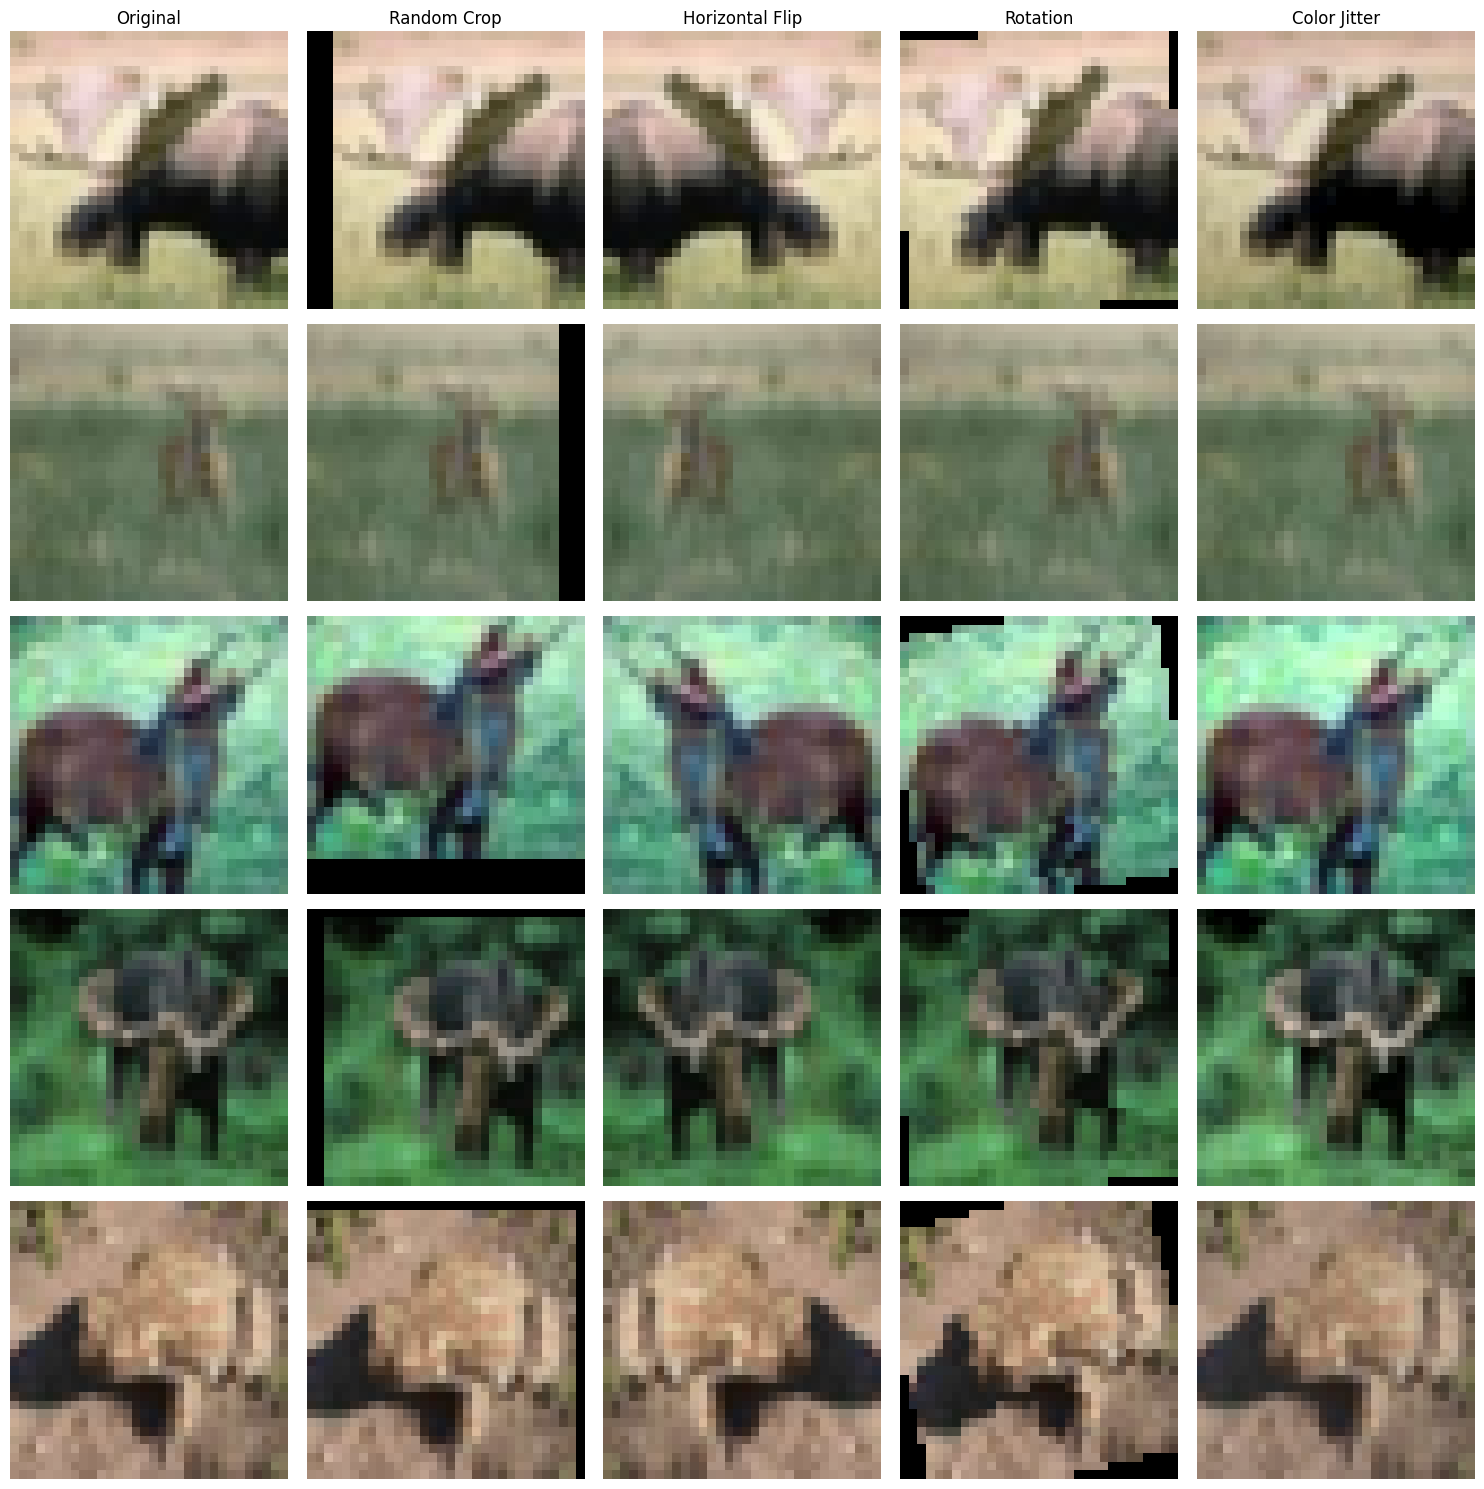


=== Running Experiment: SGD_NoScheduler ===
Model parameters: 1,149,770
Using SGD optimizer with learning rate: 0.01
No learning rate scheduler
[Epoch: 1/50] Loss: 1.5609, Accuracy: 42.46%, Learning rate: 0.010000, Time: 24.15s
[Epoch: 2/50] Loss: 1.1763, Accuracy: 58.06%, Learning rate: 0.010000, Time: 23.82s
[Epoch: 3/50] Loss: 1.0097, Accuracy: 64.23%, Learning rate: 0.010000, Time: 24.00s
[Epoch: 4/50] Loss: 0.9044, Accuracy: 68.18%, Learning rate: 0.010000, Time: 23.73s
[Epoch: 5/50] Loss: 0.8305, Accuracy: 71.01%, Learning rate: 0.010000, Time: 24.32s
[Epoch: 6/50] Loss: 0.7727, Accuracy: 73.17%, Learning rate: 0.010000, Time: 23.89s
[Epoch: 7/50] Loss: 0.7275, Accuracy: 74.88%, Learning rate: 0.010000, Time: 23.74s
[Epoch: 8/50] Loss: 0.6923, Accuracy: 76.09%, Learning rate: 0.010000, Time: 24.69s
[Epoch: 9/50] Loss: 0.6587, Accuracy: 77.17%, Learning rate: 0.010000, Time: 24.03s
[Epoch: 10/50] Loss: 0.6287, Accuracy: 78.46%, Learning rate: 0.010000, Time: 24.23s
[Epoch: 11/50]

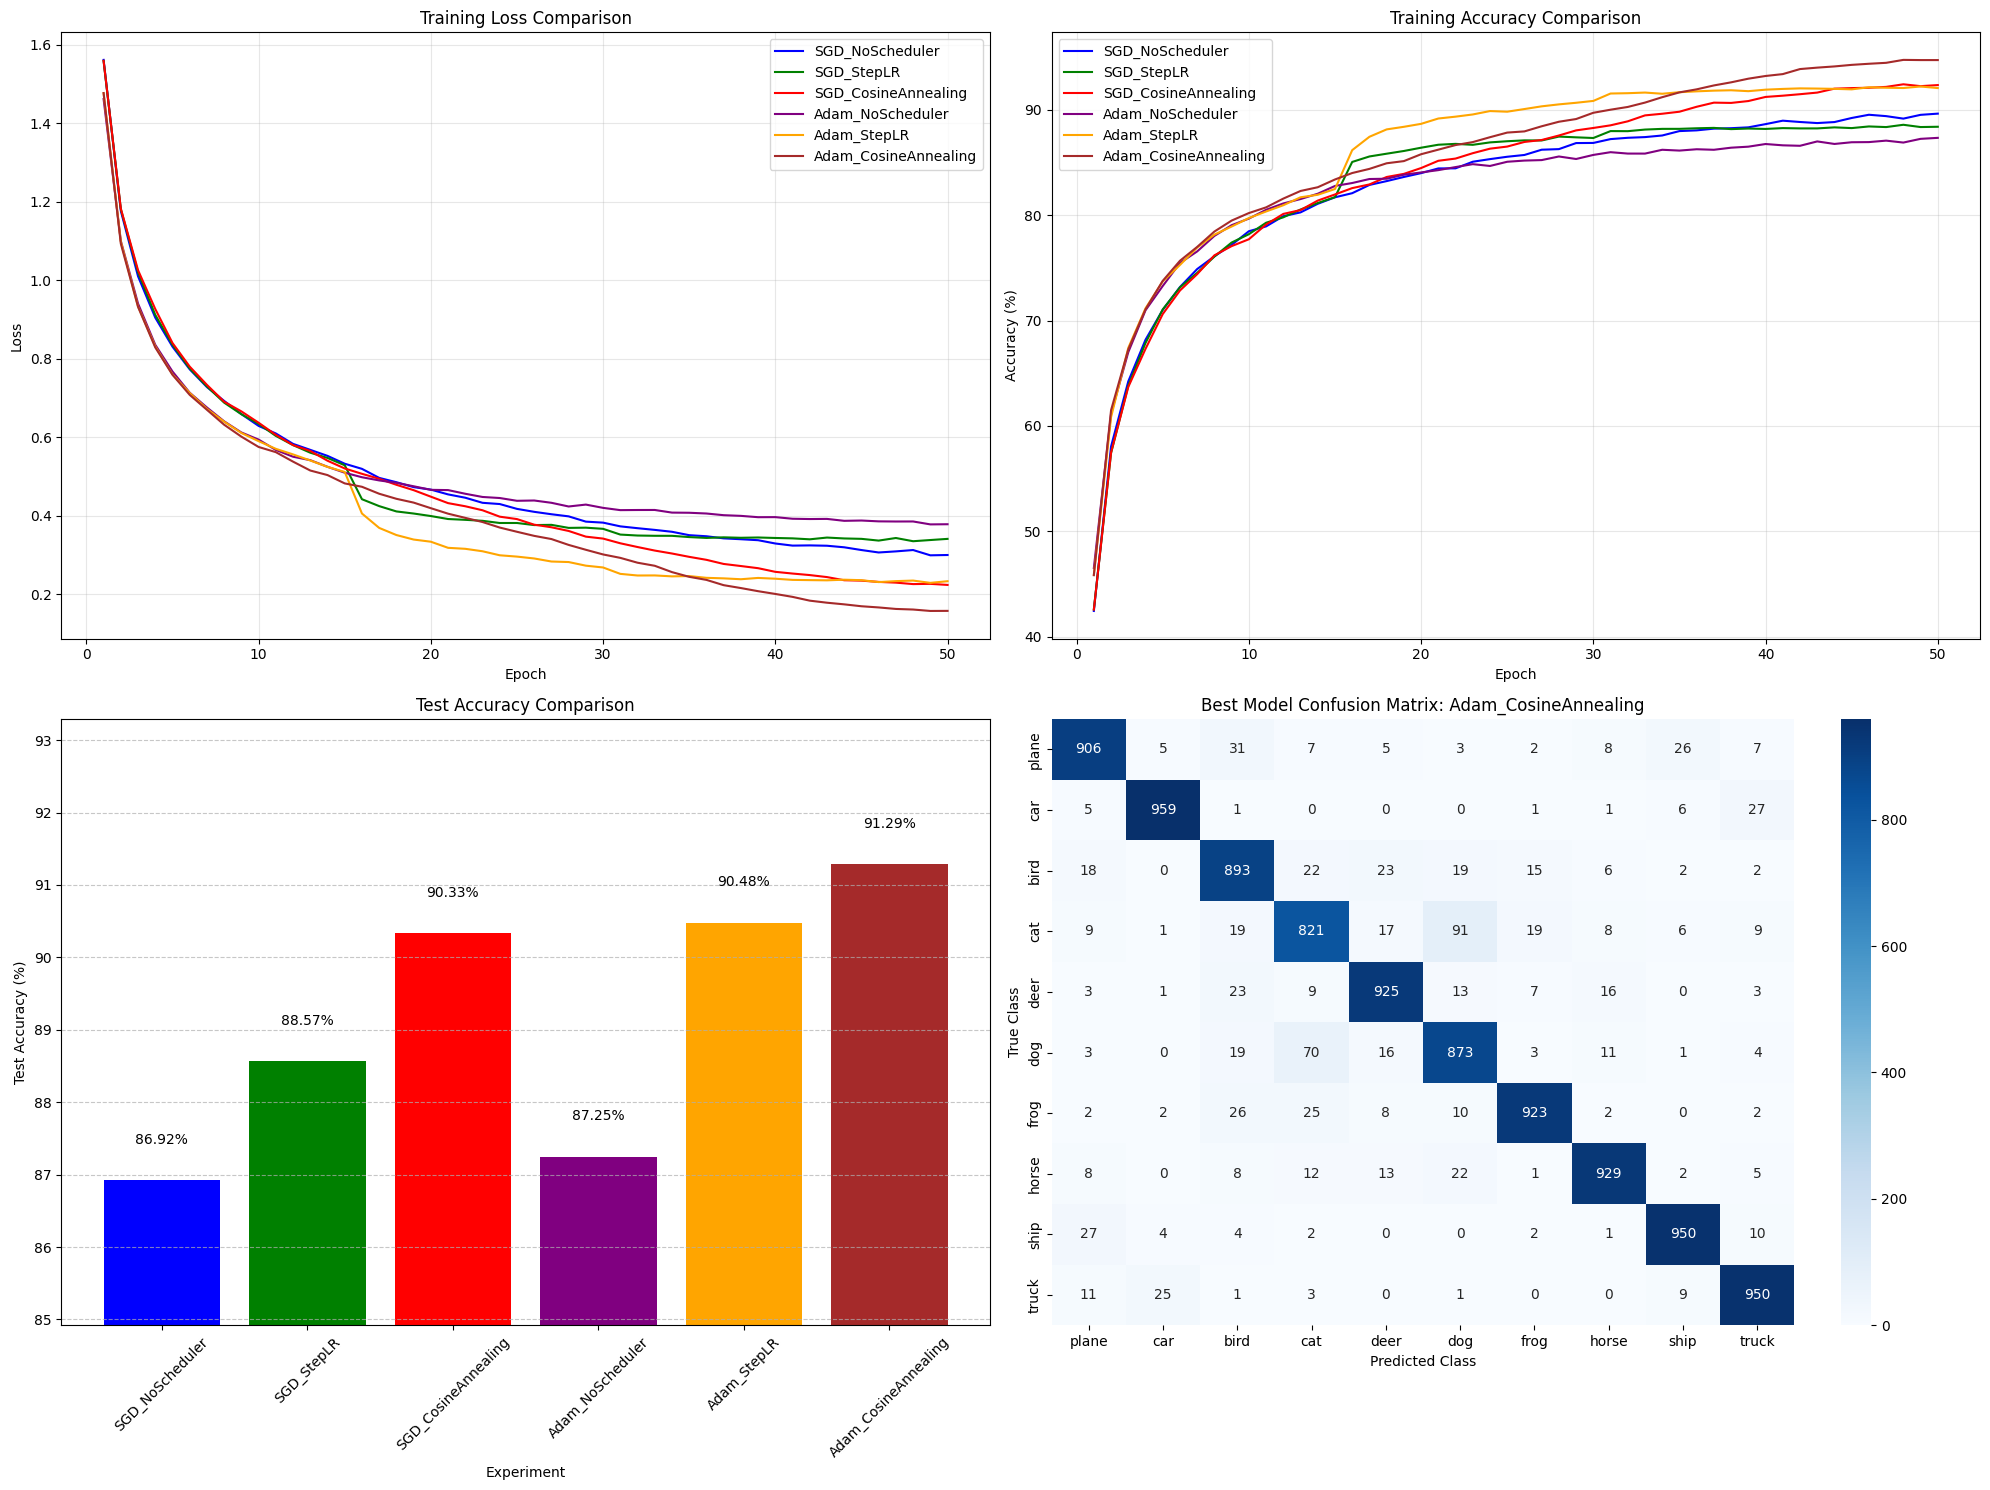

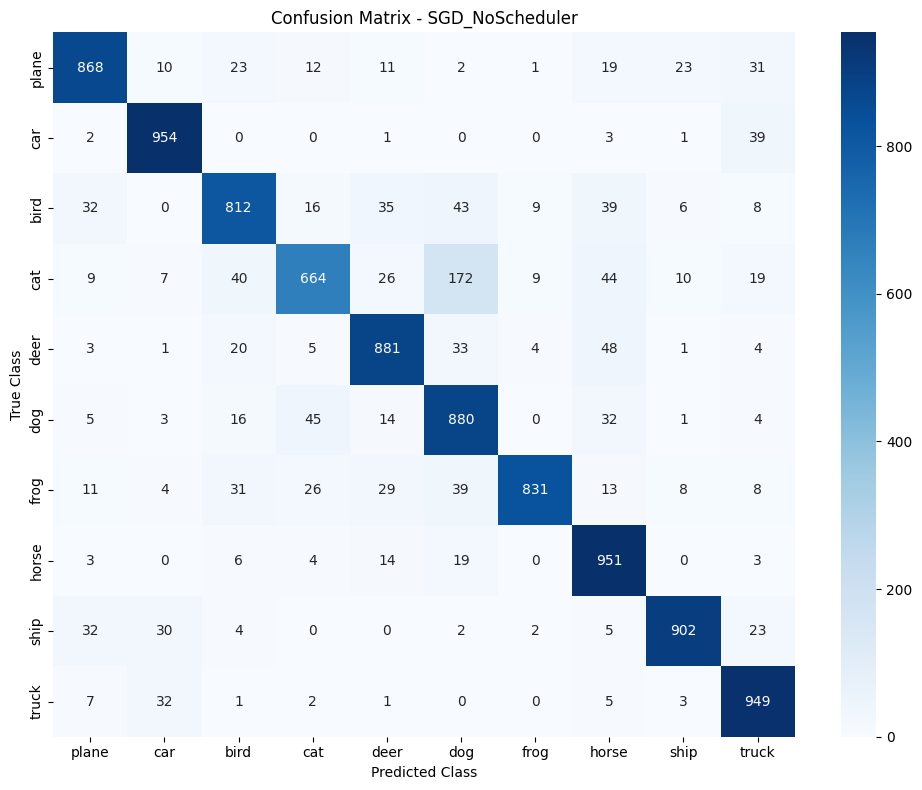

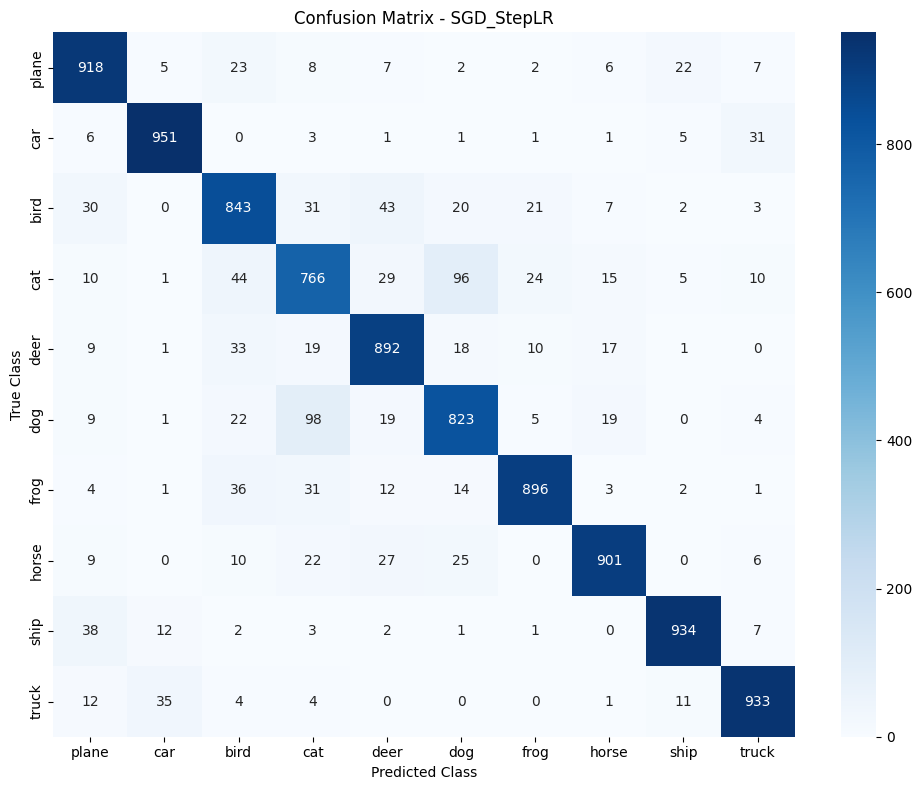

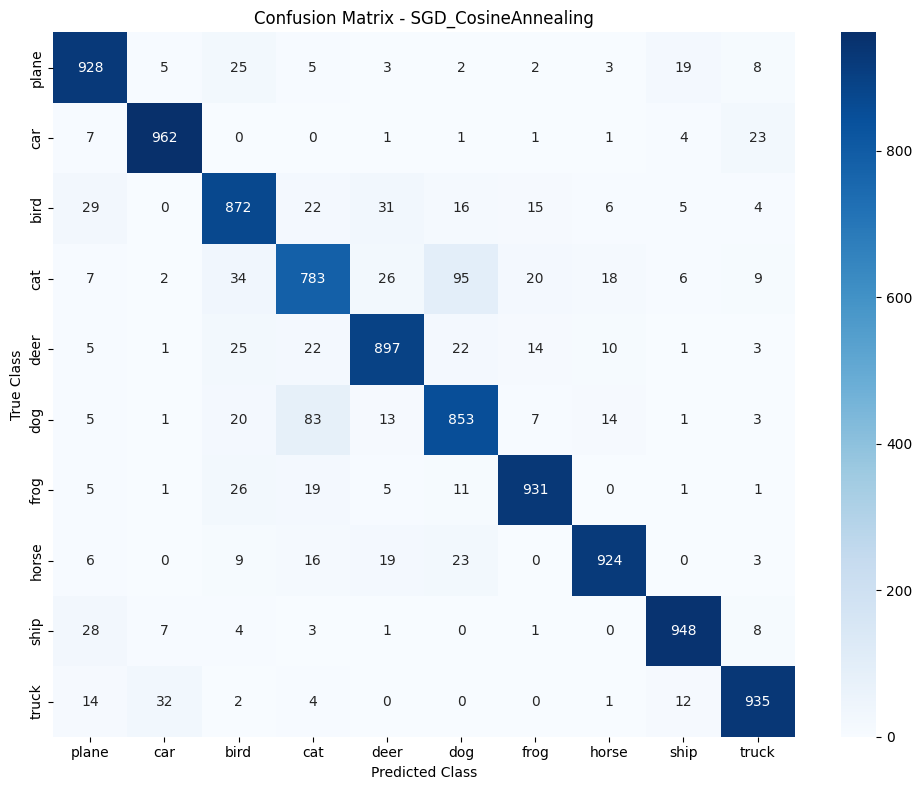

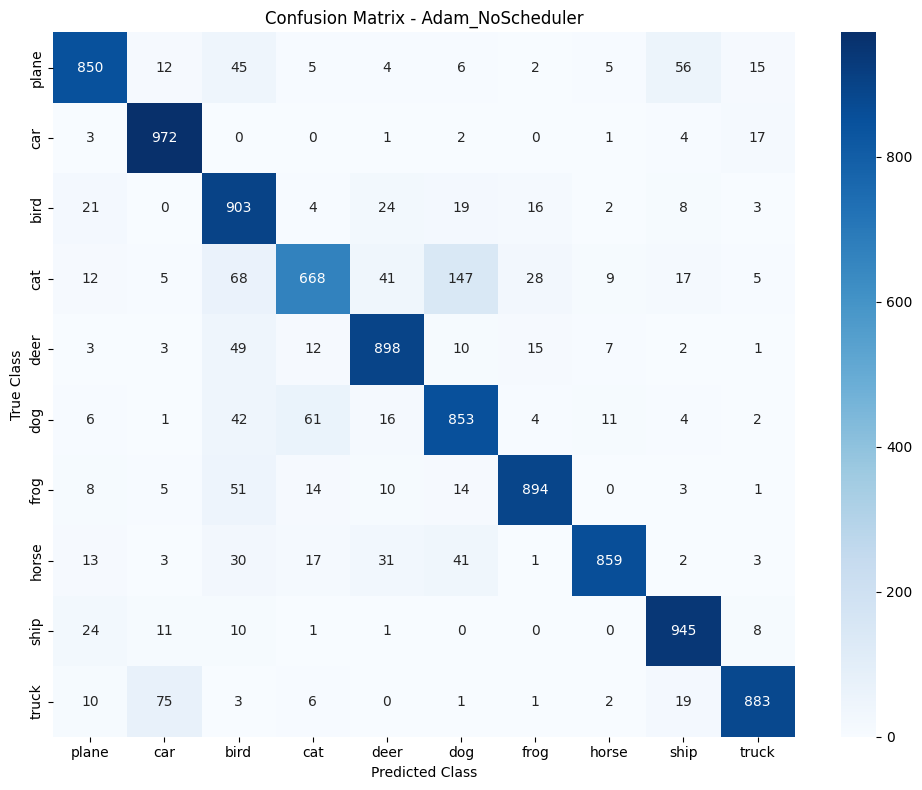

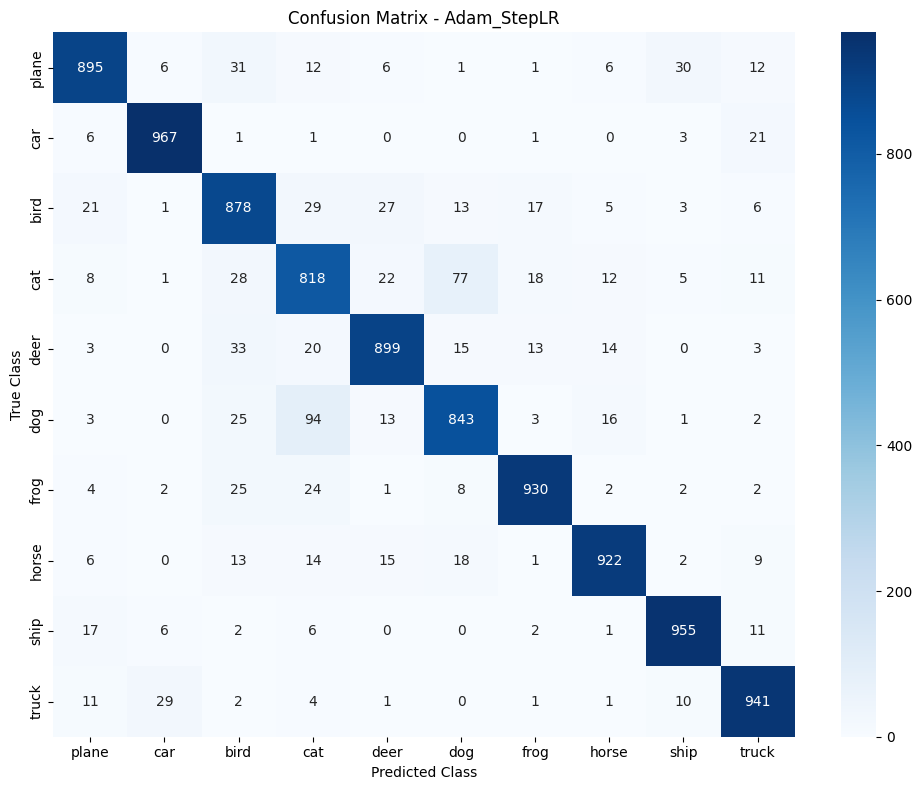

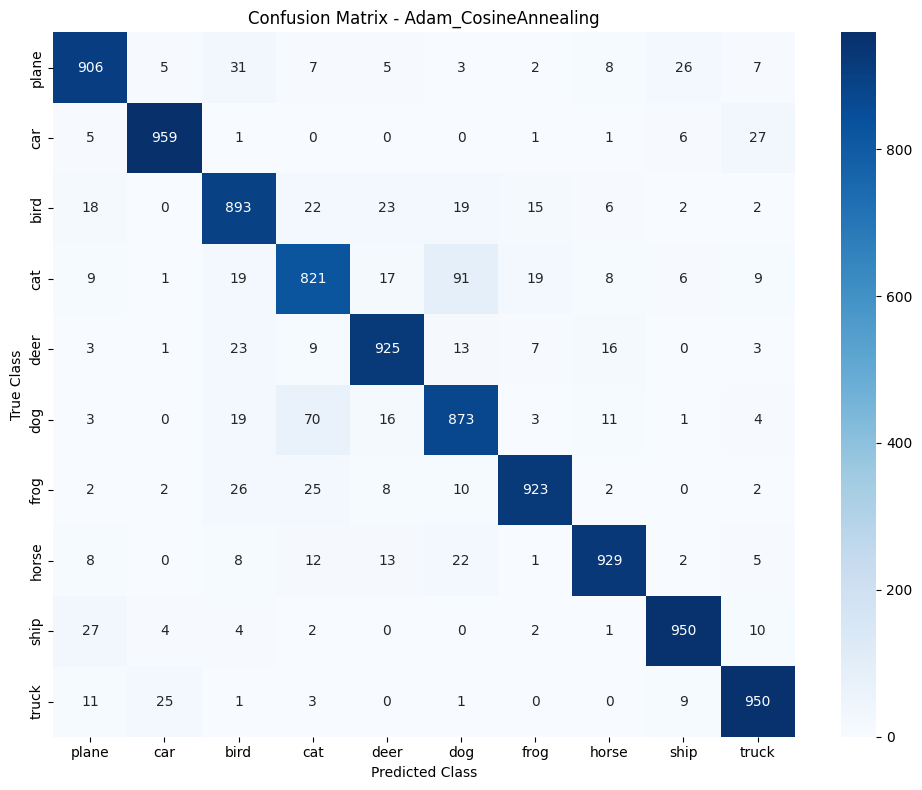

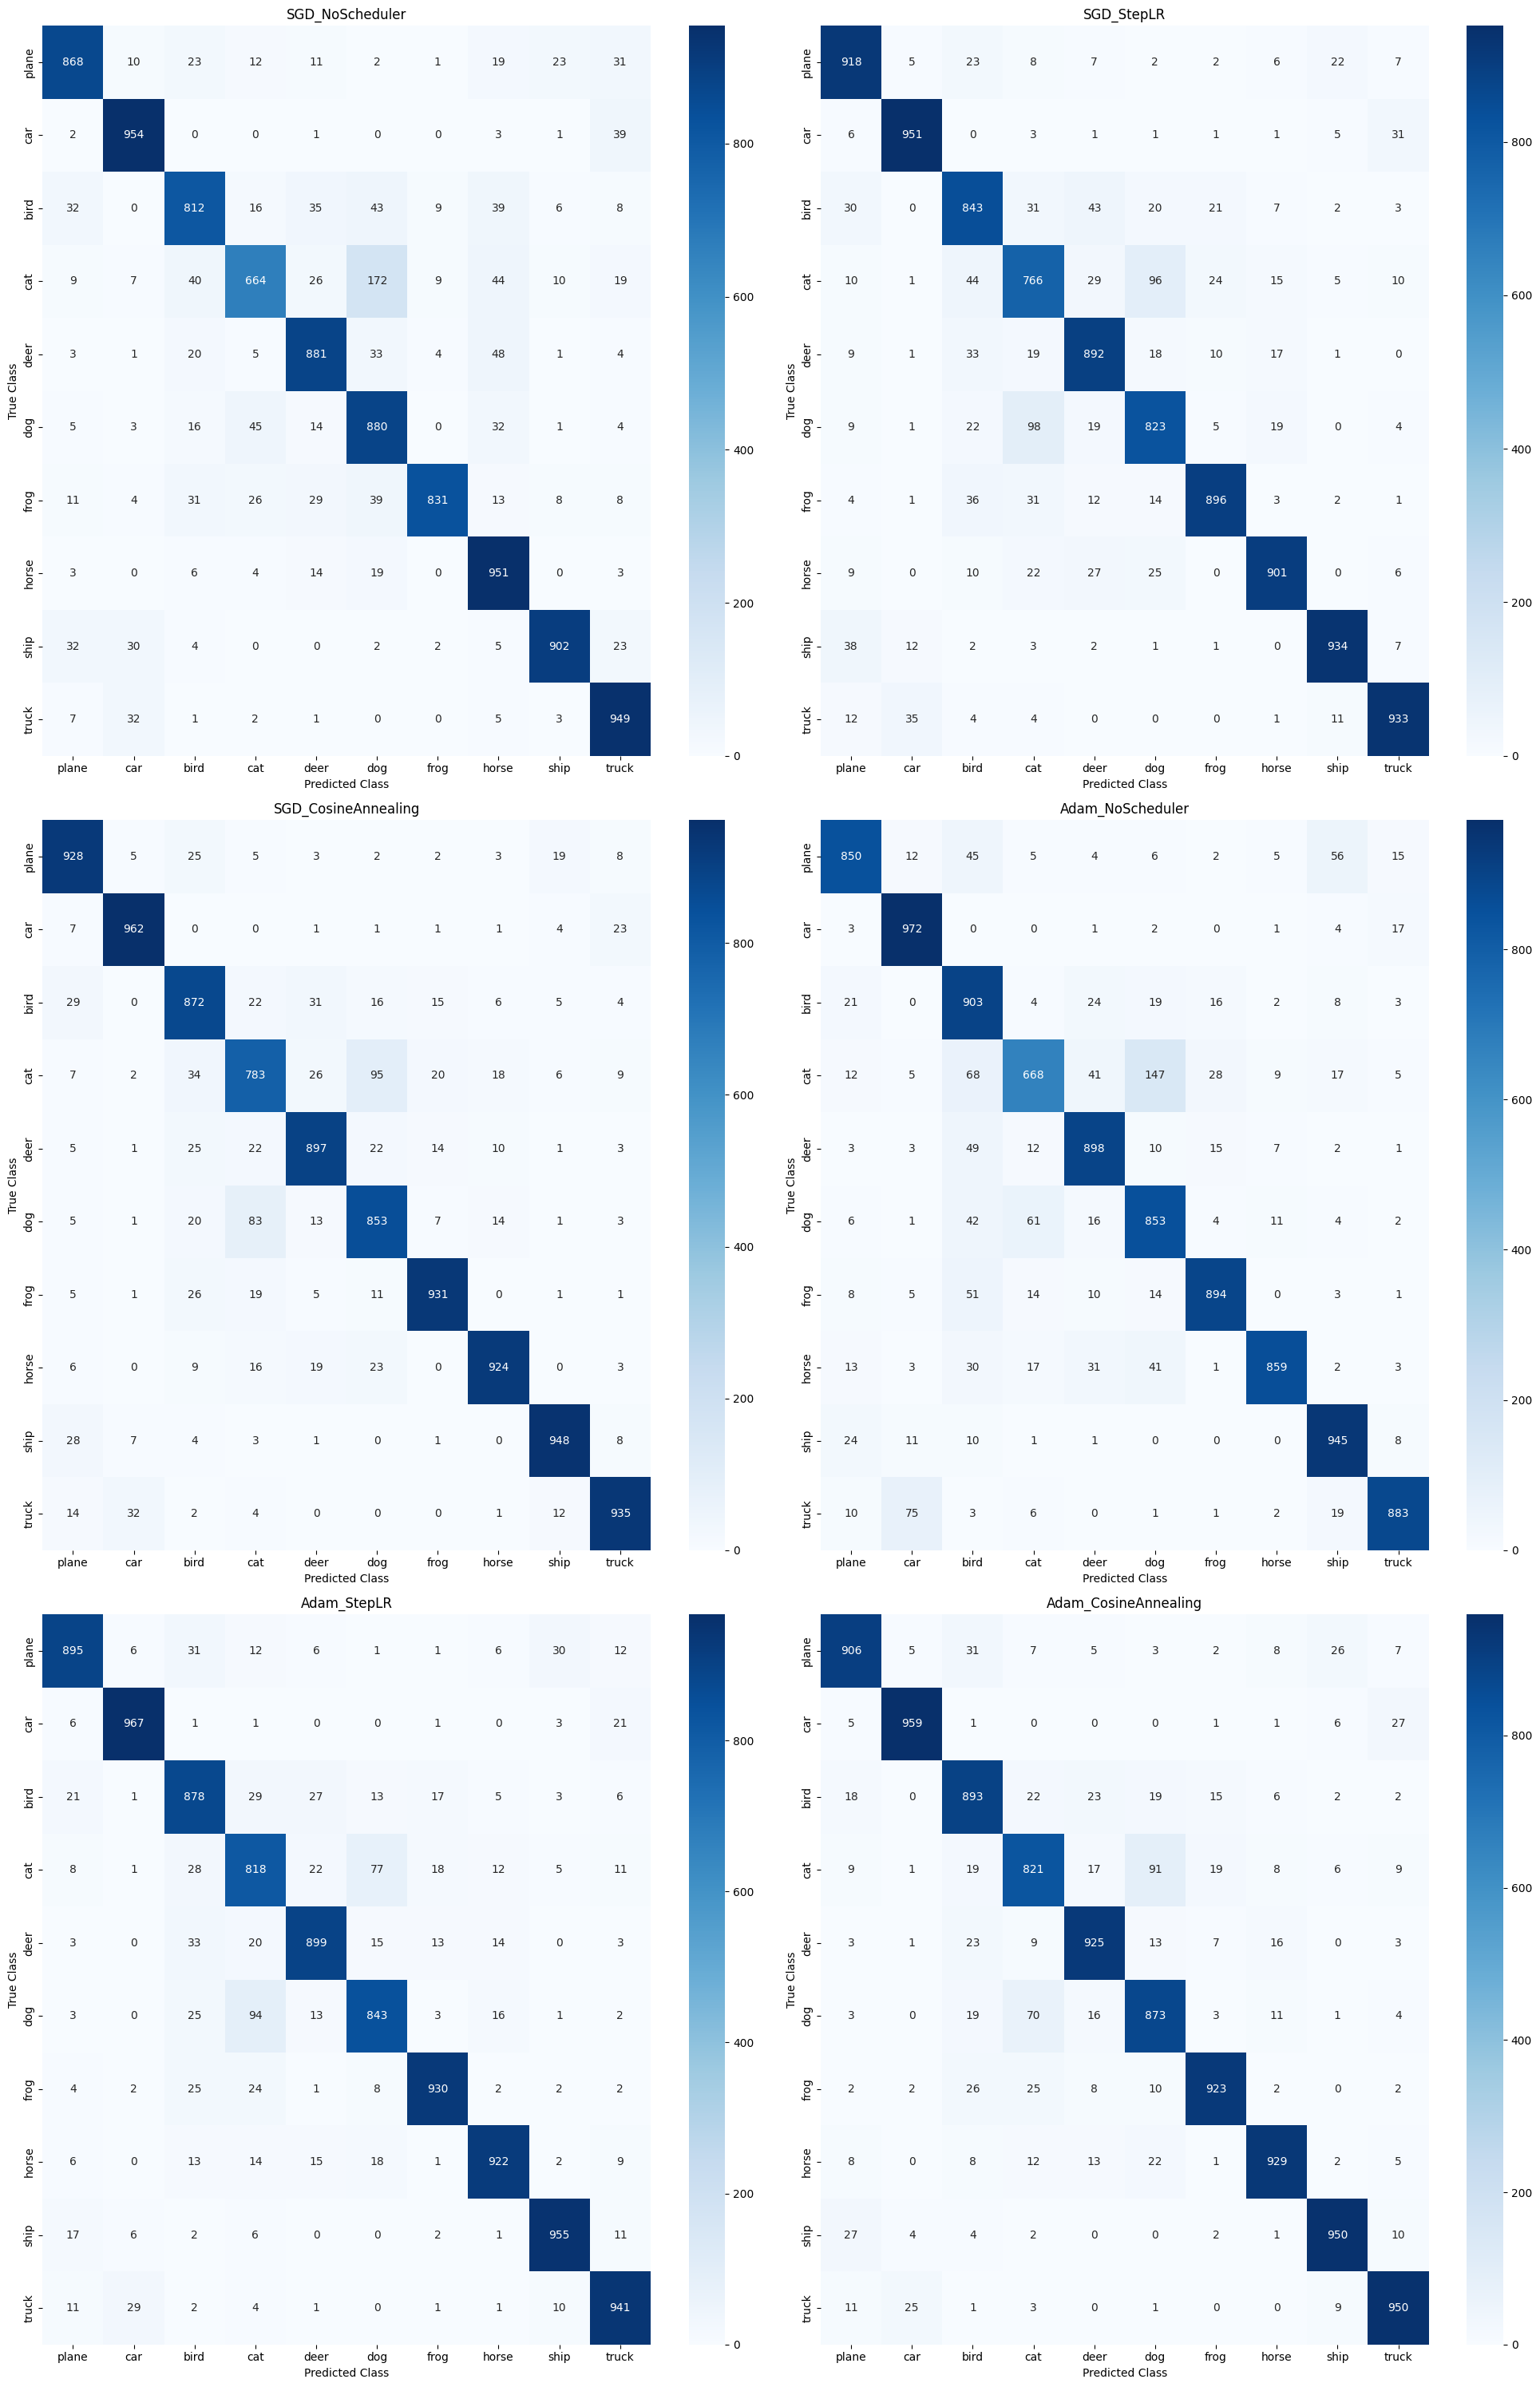

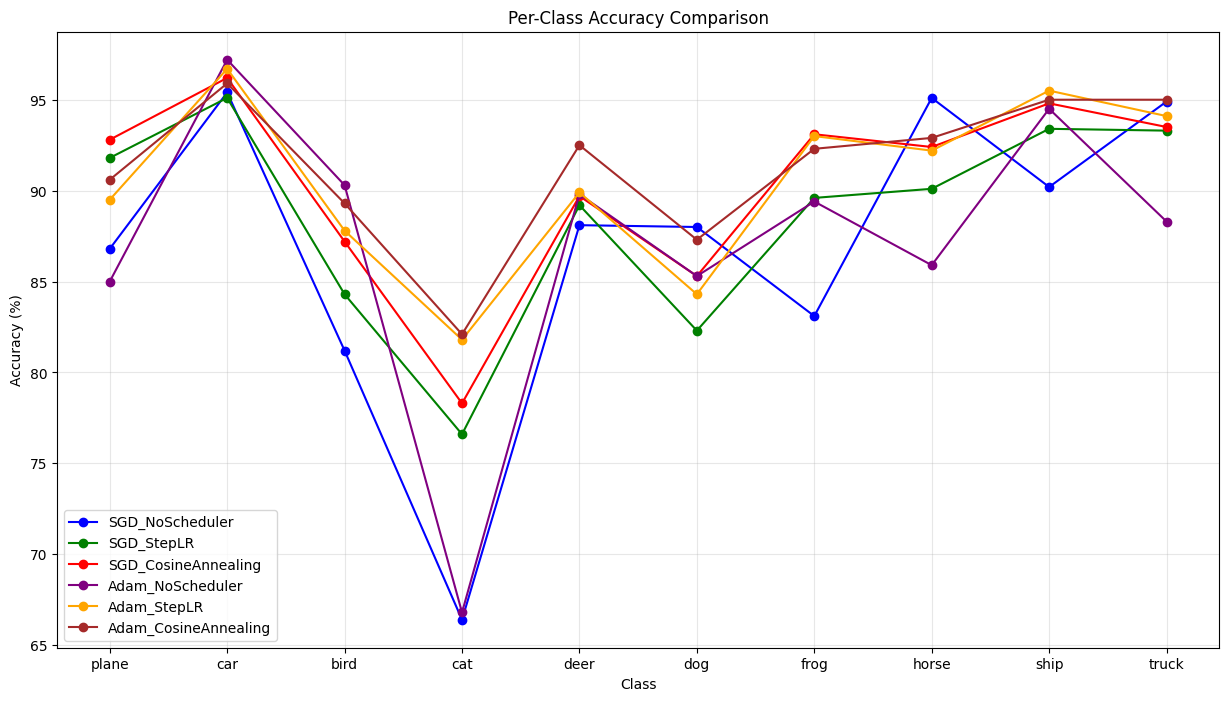


=== All Experiments Completed ===
SGD_NoScheduler: Test Accuracy = 86.92%
SGD_StepLR: Test Accuracy = 88.57%
SGD_CosineAnnealing: Test Accuracy = 90.33%
Adam_NoScheduler: Test Accuracy = 87.25%
Adam_StepLR: Test Accuracy = 90.48%
Adam_CosineAnnealing: Test Accuracy = 91.29%


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import time

# =============================================================================
# 1. Data Preprocessing and Augmentation
# =============================================================================

def get_transforms(use_augmentation=False):
    """
    Create transformation pipelines for training and testing data.

    Args:
        use_augmentation (bool): Whether to apply data augmentation

    Returns:
        transforms.Compose: Transformation pipeline
    """
    # CIFAR-10 normalization values
    mean = (0.4914, 0.4822, 0.4465)
    std = (0.2023, 0.1994, 0.2010)

    # Basic transform for testing data - only normalization
    basic_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

    if not use_augmentation:
        return basic_transform

    # Enhanced transform with data augmentation for training data
    augmented_transform = transforms.Compose([
        # Random crop with padding to maintain image size
        transforms.RandomCrop(32, padding=4),
        # Random horizontal flip with 50% probability
        transforms.RandomHorizontalFlip(),
        # Random rotation up to 15 degrees
        transforms.RandomRotation(15),
        # Color jitter to simulate different lighting conditions
        transforms.ColorJitter(
            brightness=0.2,
            contrast=0.2,
            saturation=0.2,
            hue=0.1
        ),
        # Convert to tensor and normalize
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

    return augmented_transform

def load_data(batch_size=128, use_augmentation=True):
    """
    Load and prepare CIFAR-10 dataset.

    Args:
        batch_size (int): Batch size for data loaders
        use_augmentation (bool): Whether to apply data augmentation to training data

    Returns:
        tuple: (train_loader, test_loader)
    """
    # Training dataset with optional augmentation
    train_transform = get_transforms(use_augmentation)
    train_dataset = torchvision.datasets.CIFAR10(
        root='./data',
        train=True,
        download=True,
        transform=train_transform
    )
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2,
        pin_memory=True
    )

    # Test dataset (no augmentation)
    test_transform = get_transforms(False)
    test_dataset = torchvision.datasets.CIFAR10(
        root='./data',
        train=False,
        download=True,
        transform=test_transform
    )
    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
        pin_memory=True
    )

    return train_loader, test_loader

def visualize_augmentations(num_samples=5):
    """
    Visualize the effect of different augmentation techniques on sample images.

    Args:
        num_samples (int): Number of sample images to visualize
    """
    # CIFAR-10 class names
    classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

    # Load a batch of training data without augmentation
    dataset = torchvision.datasets.CIFAR10(
        root='./data',
        train=True,
        download=True,
        transform=transforms.ToTensor()
    )

    # Get sample indices
    indices = np.random.choice(len(dataset), num_samples, replace=False)

    # Create different transforms to visualize
    transforms_list = {
        'Original': transforms.Compose([transforms.ToTensor()]),
        'Random Crop': transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.ToTensor()
        ]),
        'Horizontal Flip': transforms.Compose([
            transforms.RandomHorizontalFlip(p=1.0),
            transforms.ToTensor()
        ]),
        'Rotation': transforms.Compose([
            transforms.RandomRotation(15),
            transforms.ToTensor()
        ]),
        'Color Jitter': transforms.Compose([
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
            transforms.ToTensor()
        ])
    }

    # Create figure for visualization
    fig, axes = plt.subplots(num_samples, len(transforms_list), figsize=(15, 3*num_samples))

    # Apply each transform to each sample and display
    for i, idx in enumerate(indices):
        image, label = dataset.data[idx], dataset.targets[idx]

        for j, (name, transform) in enumerate(transforms_list.items()):
            # Convert PIL image to tensor, apply transform, convert back for display
            pil_image = transforms.ToPILImage()(torch.from_numpy(image.transpose(2, 0, 1)/255))
            transformed = transform(pil_image)

            # Display the transformed image
            ax = axes[i, j]
            ax.imshow(transformed.permute(1, 2, 0))
            if i == 0:
                ax.set_title(name)
            if j == 0:
                ax.set_ylabel(f"Sample {i+1}\nClass: {classes[label]}")
            ax.axis('off')

    plt.tight_layout()
    plt.show()

# =============================================================================
# 2. CNN Model Design and Implementation
# =============================================================================

class CustomCNN(nn.Module):
    """
    Custom CNN architecture for CIFAR-10 classification.
    Features multiple convolutional layers with batch normalization,
    dropout for regularization, and global average pooling.
    """
    def __init__(self, dropout_rate=0.3):
        """
        Initialize the CNN model.

        Args:
            dropout_rate (float): Dropout probability for regularization
        """
        super(CustomCNN, self).__init__()

        # First convolutional block
        self.conv1 = nn.Sequential(
            # Input: 3x32x32, Output: 64x32x32
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            # Input: 64x32x32, Output: 64x32x32
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            # Input: 64x32x32, Output: 64x16x16
            nn.MaxPool2d(2)
        )

        # Second convolutional block
        self.conv2 = nn.Sequential(
            # Input: 64x16x16, Output: 128x16x16
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            # Input: 128x16x16, Output: 128x16x16
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            # Input: 128x16x16, Output: 128x8x8
            nn.MaxPool2d(2)
        )

        # Third convolutional block
        self.conv3 = nn.Sequential(
            # Input: 128x8x8, Output: 256x8x8
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            # Input: 256x8x8, Output: 256x8x8
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            # Input: 256x8x8, Output: 256x4x4
            nn.MaxPool2d(2)
        )

        # Global average pooling
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))

        # Fully connected layers for classification
        self.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            # Input: 256, Output: 10
            nn.Linear(256, 10)
        )

    def forward(self, x):
        """
        Forward pass through the CNN.

        Args:
            x (torch.Tensor): Input tensor of shape [batch_size, 3, 32, 32]

        Returns:
            torch.Tensor: Output logits of shape [batch_size, 10]
        """
        # Pass through convolutional blocks
        x = self.conv1(x)  # Output: [batch_size, 64, 16, 16]
        x = self.conv2(x)  # Output: [batch_size, 128, 8, 8]
        x = self.conv3(x)  # Output: [batch_size, 256, 4, 4]

        # Global average pooling
        x = self.global_avg_pool(x)  # Output: [batch_size, 256, 1, 1]
        x = x.view(x.size(0), -1)    # Output: [batch_size, 256]

        # Fully connected layer
        x = self.fc(x)  # Output: [batch_size, 10]

        return x

# =============================================================================
# 3. Model Training and Optimization
# =============================================================================

def train_model(model, train_loader, optimizer, scheduler, criterion, epochs, device):
    """
    Train the model for the specified number of epochs.

    Args:
        model (nn.Module): The neural network model to train
        train_loader (DataLoader): DataLoader for training data
        optimizer (torch.optim.Optimizer): Optimizer for training
        scheduler (torch.optim.lr_scheduler._LRScheduler): Learning rate scheduler
        criterion (nn.Module): Loss function
        epochs (int): Number of training epochs
        device (torch.device): Device to use for training

    Returns:
        tuple: (train_losses, train_accs) - Lists of training losses and accuracies
    """
    model.to(device)

    train_losses = []
    train_accs = []

    for epoch in range(epochs):
        start_time = time.time()
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Track statistics
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

        # Calculate epoch statistics
        epoch_loss = running_loss / total
        epoch_acc = 100 * correct / total
        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc)

        # Step the scheduler if provided
        if scheduler is not None:
            scheduler.step()

        end_time = time.time()
        current_lr = optimizer.param_groups[0]['lr']
        print(f'[Epoch: {epoch + 1}/{epochs}] Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%, '
              f'Learning rate: {current_lr:.6f}, Time: {end_time - start_time:.2f}s')

    return train_losses, train_accs

def evaluate_model(model, test_loader, device):
    """
    Evaluate the model on the test dataset.

    Args:
        model (nn.Module): The neural network model to evaluate
        test_loader (DataLoader): DataLoader for test data
        device (torch.device): Device to use for evaluation

    Returns:
        tuple: (accuracy, confusion_matrix) - Test accuracy and confusion matrix
    """
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            total += targets.size(0)
            correct += (predicted == targets).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(targets.cpu().numpy())

    accuracy = 100 * correct / total
    print(f'Test set accuracy: {accuracy:.2f}%')

    # Create confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    return accuracy, cm

# =============================================================================
# 4. Visualization and Analysis
# =============================================================================

def compare_experiment_results(results, epochs, classes):
    """
    Compare and visualize results from different experiments.

    Args:
        results (dict): Dictionary containing results for different experiments
        epochs (int): Number of training epochs
        classes (list): List of class names
    """
    # Extract experiment names and results
    names = list(results.keys())

    # Create figure for comparison plots
    plt.figure(figsize=(20, 15))

    # Plot training loss
    plt.subplot(2, 2, 1)
    for name in names:
        plt.plot(range(1, epochs + 1), results[name]['losses'],
                 label=name, color=results[name]['color'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Comparison')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot training accuracy
    plt.subplot(2, 2, 2)
    for name in names:
        plt.plot(range(1, epochs + 1), results[name]['accs'],
                 label=name, color=results[name]['color'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Training Accuracy Comparison')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot test accuracy comparison
    plt.subplot(2, 2, 3)
    test_accs = [results[name]['test_acc'] for name in names]
    colors = [results[name]['color'] for name in names]

    bars = plt.bar(names, test_accs, color=colors)
    plt.xlabel('Experiment')
    plt.ylabel('Test Accuracy (%)')
    plt.title('Test Accuracy Comparison')
    plt.xticks(rotation=45)

    # Add accuracy values on top of bars
    for i, v in enumerate(test_accs):
        plt.text(i, v + 0.5, f"{v:.2f}%", ha='center')

    # Set y-axis limits to better visualize differences
    plt.ylim(min(test_accs) - 2, max(test_accs) + 2)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Plot best model's confusion matrix in the fourth subplot
    plt.subplot(2, 2, 4)
    best_model = max(results.items(), key=lambda x: x[1]['test_acc'])[0]
    sns.heatmap(results[best_model]['cm'], annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Class')
    plt.ylabel('True Class')
    plt.title(f'Best Model Confusion Matrix: {best_model}')

    plt.tight_layout()
    plt.savefig('comparison_results.png')
    plt.show()

    # Create a separate figure for combined confusion matrices
    num_models = len(results)
    rows = (num_models + 1) // 2
    fig, axes = plt.subplots(rows, 2, figsize=(20, 10 * rows))
    axes = axes.flatten() if rows > 1 else [axes] if num_models == 1 else axes

    for i, name in enumerate(names):
        sns.heatmap(results[name]['cm'], annot=True, fmt='d', cmap='Blues',
                   xticklabels=classes, yticklabels=classes, ax=axes[i])
        axes[i].set_title(f'{name}')
        axes[i].set_xlabel('Predicted Class')
        axes[i].set_ylabel('True Class')

    # Remove unused subplots if odd number of models
    if num_models % 2 != 0 and num_models > 1:
        fig.delaxes(axes[-1])

    plt.tight_layout()
    plt.savefig('all_confusion_matrices.png')
    plt.show()

    # Additional plot for per-class accuracy comparison
    plt.figure(figsize=(15, 8))

    # Calculate per-class accuracy for each experiment
    class_accs = {}
    for name in names:
        cm = results[name]['cm']
        per_class_acc = cm.diagonal() / cm.sum(axis=1) * 100
        class_accs[name] = per_class_acc

    # Plot per-class accuracy
    for name in names:
        plt.plot(range(len(classes)), class_accs[name],
                 marker='o', label=name, color=results[name]['color'])

    plt.xticks(range(len(classes)), classes)
    plt.xlabel('Class')
    plt.ylabel('Accuracy (%)')
    plt.title('Per-Class Accuracy Comparison')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig('per_class_accuracy_comparison.png')
    plt.show()

# =============================================================================
# 5. Main Execution - Optimizer and Scheduler Comparison
# =============================================================================

def main():
    print("\n=== CIFAR-10 Classification: Optimizer and Scheduler Comparison ===")

    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Using device: {device}')

    # CIFAR-10 class names
    classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

    # Hyperparameters
    batch_size = 128
    epochs = 50
    base_lr = 0.01  # For SGD
    adam_lr = 0.001  # For Adam
    weight_decay = 5e-4
    dropout_rate = 0.3

    # Visualize data augmentation
    visualize_augmentations()

    # Load data with augmentation
    train_loader, test_loader = load_data(batch_size, use_augmentation=True)

    # Define experiment configurations
    experiment_configs = {
        'SGD_NoScheduler': {
            'optimizer': 'sgd',
            'lr': base_lr,
            'scheduler': None,
            'color': 'blue'
        },
        'SGD_StepLR': {
            'optimizer': 'sgd',
            'lr': base_lr,
            'scheduler': 'step',
            'step_size': 15,
            'gamma': 0.1,
            'color': 'green'
        },
        'SGD_CosineAnnealing': {
            'optimizer': 'sgd',
            'lr': base_lr,
            'scheduler': 'cosine',
            'T_max': epochs,
            'color': 'red'
        },
        'Adam_NoScheduler': {
            'optimizer': 'adam',
            'lr': adam_lr,
            'scheduler': None,
            'color': 'purple'
        },
        'Adam_StepLR': {
            'optimizer': 'adam',
            'lr': adam_lr,
            'scheduler': 'step',
            'step_size': 15,
            'gamma': 0.1,
            'color': 'orange'
        },
        'Adam_CosineAnnealing': {
            'optimizer': 'adam',
            'lr': adam_lr,
            'scheduler': 'cosine',
            'T_max': epochs,
            'color': 'brown'
        }
    }

    # Store results for comparison
    all_results = {}

    # Run experiments
    for name, config in experiment_configs.items():
        print(f"\n=== Running Experiment: {name} ===")

        # Create model
        model = CustomCNN(dropout_rate=dropout_rate).to(device)
        print(f"Model parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

        # Create optimizer
        if config['optimizer'] == 'sgd':
            optimizer = optim.SGD(
                model.parameters(),
                lr=config['lr'],
                momentum=0.9,
                weight_decay=weight_decay
            )
            print(f"Using SGD optimizer with learning rate: {config['lr']}")
        else:  # adam
            optimizer = optim.Adam(
                model.parameters(),
                lr=config['lr'],
                weight_decay=weight_decay
            )
            print(f"Using Adam optimizer with learning rate: {config['lr']}")

        # Create scheduler
        if config['scheduler'] is None:
            scheduler = None
            print("No learning rate scheduler")
        elif config['scheduler'] == 'step':
            scheduler = optim.lr_scheduler.StepLR(
                optimizer,
                step_size=config['step_size'],
                gamma=config['gamma']
            )
            print(f"Using StepLR scheduler with step_size={config['step_size']}, gamma={config['gamma']}")
        elif config['scheduler'] == 'cosine':
            scheduler = optim.lr_scheduler.CosineAnnealingLR(
                optimizer,
                T_max=config['T_max'],
                eta_min=0
            )
            print(f"Using CosineAnnealingLR scheduler with T_max={config['T_max']}")

        # Loss function
        criterion = nn.CrossEntropyLoss()

        # Train model
        train_losses, train_accs = train_model(
            model, train_loader, optimizer, scheduler, criterion, epochs, device
        )

        # Evaluate model
        accuracy, cm = evaluate_model(model, test_loader, device)

        # Collect learning rates during training
        lrs = []
        for param_group in optimizer.param_groups:
            lrs.append(param_group['lr'])

        # Store results
        all_results[name] = {
            'losses': train_losses,
            'accs': train_accs,
            'test_acc': accuracy,
            'cm': cm,
            'color': config['color'],
            'final_lr': lrs[-1]
        }

    # Compare results
    compare_experiment_results(all_results, epochs, classes)

    print("\n=== All Experiments Completed ===")
    for name, result in all_results.items():
        print(f"{name}: Test Accuracy = {result['test_acc']:.2f}%")

if __name__ == "__main__":
    main()